In [110]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import plotly, pickle
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sn
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
df=pd.read_csv("Pokemon.csv",encoding='latin1')

In [3]:
df.drop("Catch_Rate",axis=1,inplace=True)

In [4]:
df.head(3)

,Number,Name,Type_1,Type_2,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Body_Style
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False,Green,True,0.875,Monster,Grass,False,0.71,6.9,quadruped
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False,Green,True,0.875,Monster,Grass,False,0.99,13.0,quadruped
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False,Green,True,0.875,Monster,Grass,True,2.01,100.0,quadruped


In [5]:
df.isnull().sum()

Number                0
Name                  0
Type_1                0
Type_2              371
Total                 0
HP                    0
Attack                0
Defense               0
Sp_Atk                0
Sp_Def                0
Speed                 0
Generation            0
isLegendary           0
Color                 0
hasGender             0
Pr_Male              77
Egg_Group_1           0
Egg_Group_2         530
hasMegaEvolution      0
Height_m              0
Weight_kg             0
Body_Style            0
dtype: int64

In [6]:
df.dtypes

Number                int64
Name                 object
Type_1               object
Type_2               object
Total                 int64
HP                    int64
Attack                int64
Defense               int64
Sp_Atk                int64
Sp_Def                int64
Speed                 int64
Generation            int64
isLegendary            bool
Color                object
hasGender              bool
Pr_Male             float64
Egg_Group_1          object
Egg_Group_2          object
hasMegaEvolution       bool
Height_m            float64
Weight_kg           float64
Catch_Rate            int64
Body_Style           object
dtype: object

# Missing value treatment

In [109]:
df.isnull().sum()

HP                               0
Attack                           0
Defense                          0
Sp_Atk                           0
Sp_Def                           0
Speed                            0
Generation                       0
isLegendary                      0
hasGender                        0
Pr_Male                         77
hasMegaEvolution                 0
Height_m                         0
Weight_kg                        0
Type_1_Bug                       0
Type_1_Dark                      0
Type_1_Dragon                    0
Type_1_Electric                  0
Type_1_Fairy                     0
Type_1_Fighting                  0
Type_1_Fire                      0
Type_1_Flying                    0
Type_1_Ghost                     0
Type_1_Grass                     0
Type_1_Ground                    0
Type_1_Ice                       0
Type_1_Normal                    0
Type_1_Poison                    0
Type_1_Psychic                   0
Type_1_Rock         

In [7]:
df.hasGender.value_counts()

True     644
False     77
Name: hasGender, dtype: int64

In [ ]:
# We will not be imputing missing values of Pr_Male and let lightgbm algorithm handle it

In [8]:
# Imputing
df.loc[df.Type_2.isnull(),'Type_2']="No 2nd type"
df.loc[df.Egg_Group_2.isnull(),'Egg_Group_2']="No 2nd egg group"

In [9]:
df.isnull().sum()

Number               0
Name                 0
Type_1               0
Type_2               0
Total                0
HP                   0
Attack               0
Defense              0
Sp_Atk               0
Sp_Def               0
Speed                0
Generation           0
isLegendary          0
Color                0
hasGender            0
Pr_Male             77
Egg_Group_1          0
Egg_Group_2          0
hasMegaEvolution     0
Height_m             0
Weight_kg            0
Body_Style           0
dtype: int64

# Outliers and preprocessing

In [11]:
#Analyze numeric variables to check if any outliers --- LOOKS OK
round(df.describe(percentiles=[0.5,0.95,.99]))

,Number,Total,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,Pr_Male,Height_m,Weight_kg
count,721.0,721.0,721.0,721.0,721.0,721.0,721.0,721.0,721.0,644.0,721.0,721.0
mean,361.0,418.0,68.0,75.0,71.0,69.0,69.0,66.0,3.0,1.0,1.0,57.0
std,208.0,110.0,26.0,29.0,29.0,29.0,27.0,27.0,2.0,0.0,1.0,89.0
min,1.0,180.0,1.0,5.0,5.0,10.0,20.0,5.0,1.0,0.0,0.0,0.0
50%,361.0,424.0,65.0,74.0,65.0,65.0,65.0,65.0,3.0,0.0,1.0,28.0
95%,685.0,600.0,110.0,125.0,125.0,125.0,120.0,110.0,6.0,1.0,2.0,220.0
99%,714.0,680.0,150.0,146.0,158.0,149.0,150.0,129.0,6.0,1.0,6.0,416.0
max,721.0,720.0,255.0,165.0,230.0,154.0,230.0,160.0,6.0,1.0,14.0,950.0


In [17]:
#checking if sum of all stats is equal to 'Total'
sum(df[['HP','Attack','Defense','Sp_Atk','Sp_Def','Speed']].sum(axis=1)==df.Total)

721

In [18]:
# drop 'Total'
df.drop('Total',axis=1,inplace=True)

In [19]:
df.head()

,Number,Name,Type_1,Type_2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Body_Style
0,1,Bulbasaur,Grass,Poison,45,49,49,65,65,45,1,False,Green,True,0.875,Monster,Grass,False,0.71,6.9,quadruped
1,2,Ivysaur,Grass,Poison,60,62,63,80,80,60,1,False,Green,True,0.875,Monster,Grass,False,0.99,13.0,quadruped
2,3,Venusaur,Grass,Poison,80,82,83,100,100,80,1,False,Green,True,0.875,Monster,Grass,True,2.01,100.0,quadruped
3,4,Charmander,Fire,No 2nd type,39,52,43,60,50,65,1,False,Red,True,0.875,Monster,Dragon,False,0.61,8.5,bipedal_tailed
4,5,Charmeleon,Fire,No 2nd type,58,64,58,80,65,80,1,False,Red,True,0.875,Monster,Dragon,False,1.09,19.0,bipedal_tailed


In [20]:
# drop 'Number'
df.drop('Number',axis=1,inplace=True)

In [21]:
# drop 'Name'
df.drop('Name',axis=1,inplace=True)

In [24]:
#Columns which are objects
for col in df.columns:
    if df[col].dtype=='object':
        print(col)

Type_1
Type_2
Color
Egg_Group_1
Egg_Group_2
Body_Style


In [31]:
#attributes with more than 20 unique values
print("Following attributes have more than 20 unique values:")
count=0
for attribute in df.columns:
    if df[attribute].dtype=='object' and df[attribute].nunique()>20:
        print('-----------------------------------')
        print(attribute)
        print('Unique values:',df[attribute].nunique())
        count+=1
#         print(df[attribute].value_counts())
print(count,"attributes have more than 20 unique values")

Following attributes have more than 20 unique values:
0 attributes have more than 20 unique values


In [32]:
#Relative frequency within attributes with <= 20 unique values --- LOOKS OK
for attribute in df.columns:
    if df[attribute].dtype=='object' and df[attribute].nunique()<=30:
        print('-----------------------------------')
        print(attribute)
        print('Unique values:',df[attribute].nunique())
        print(round(df[attribute].value_counts(normalize=True),2)*100)

-----------------------------------
Type_1
Unique values: 18
Water       15.0
Normal      13.0
Grass        9.0
Bug          9.0
Fire         7.0
Psychic      7.0
Rock         6.0
Electric     5.0
Ground       4.0
Poison       4.0
Dark         4.0
Fighting     3.0
Dragon       3.0
Ghost        3.0
Ice          3.0
Steel        3.0
Fairy        2.0
Flying       0.0
Name: Type_1, dtype: float64
-----------------------------------
Type_2
Unique values: 19
No 2nd type    51.0
Flying         12.0
Poison          4.0
Ground          4.0
Psychic         4.0
Fighting        3.0
Steel           3.0
Fairy           2.0
Grass           2.0
Dark            2.0
Dragon          2.0
Rock            2.0
Water           2.0
Ghost           2.0
Ice             1.0
Fire            1.0
Electric        1.0
Normal          1.0
Bug             0.0
Name: Type_2, dtype: float64
-----------------------------------
Color
Unique values: 10
Blue      19.0
Brown     15.0
Green     11.0
Red       10.0
Grey      10.0

In [34]:
#Checking if we have analyzed all columns --- 3 columns are BOOLEAN
if (len([x for x in df.columns if df[x].dtype=='object'])+df.describe().shape[1]==df.shape[1]):
    print("Yes we have analyzed all columns!!!")
else:
    print('categorical columns analyzed - ',len([x for x in df.columns if df[x].dtype=='object']))
    print('numeric columns analyzed - ',df.describe().shape[1])
    print("total columns",df.shape[1])

categorical columns analyzed -  6
numeric columns analyzed -  10
total columns 19


In [ ]:
# --- 3 columns are BOOLEAN, thus we have analyzed all variables

# One-hot encoding

In [35]:
df.head()

,Type_1,Type_2,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,Color,hasGender,Pr_Male,Egg_Group_1,Egg_Group_2,hasMegaEvolution,Height_m,Weight_kg,Body_Style
0,Grass,Poison,45,49,49,65,65,45,1,False,Green,True,0.875,Monster,Grass,False,0.71,6.9,quadruped
1,Grass,Poison,60,62,63,80,80,60,1,False,Green,True,0.875,Monster,Grass,False,0.99,13.0,quadruped
2,Grass,Poison,80,82,83,100,100,80,1,False,Green,True,0.875,Monster,Grass,True,2.01,100.0,quadruped
3,Fire,No 2nd type,39,52,43,60,50,65,1,False,Red,True,0.875,Monster,Dragon,False,0.61,8.5,bipedal_tailed
4,Fire,No 2nd type,58,64,58,80,65,80,1,False,Red,True,0.875,Monster,Dragon,False,1.09,19.0,bipedal_tailed


In [36]:
#one hot encoding
print(df.shape)
for x in df.columns:
    if df[x].dtype=='object':
        print(x)
        print('Unique values:',df[x].nunique())
        print('columns in dataframe',df.shape[1])
        mdf=pd.get_dummies(df[x]).iloc[:,:-1]
        cols=mdf.columns.tolist()
        mdf.columns=[x+'_'+s for s in cols]
        
        df=pd.concat([df,mdf],axis=1)

        print('no. of columns added:',mdf.shape[1])
        
        #drop the original category column
        df.drop(x,axis=1,inplace=True)
        print('shape after encoding column',x,'-',df.shape)
        print("-----------------------------------------------------")

(721, 19)
Type_1
Unique values: 18
columns in dataframe 19
no. of columns added: 17
shape after encoding column Type_1 - (721, 35)
-----------------------------------------------------
Type_2
Unique values: 19
columns in dataframe 35
no. of columns added: 18
shape after encoding column Type_2 - (721, 52)
-----------------------------------------------------
Color
Unique values: 10
columns in dataframe 52
no. of columns added: 9
shape after encoding column Color - (721, 60)
-----------------------------------------------------
Egg_Group_1
Unique values: 15
columns in dataframe 60
no. of columns added: 14
shape after encoding column Egg_Group_1 - (721, 73)
-----------------------------------------------------
Egg_Group_2
Unique values: 14
columns in dataframe 73
no. of columns added: 13
shape after encoding column Egg_Group_2 - (721, 85)
-----------------------------------------------------
Body_Style
Unique values: 14
columns in dataframe 85
no. of columns added: 13
shape after encoding

In [37]:
df.head()

,HP,Attack,Defense,Sp_Atk,Sp_Def,Speed,Generation,isLegendary,hasGender,Pr_Male,hasMegaEvolution,Height_m,Weight_kg,Type_1_Bug,Type_1_Dark,Type_1_Dragon,Type_1_Electric,Type_1_Fairy,Type_1_Fighting,Type_1_Fire,Type_1_Flying,Type_1_Ghost,Type_1_Grass,Type_1_Ground,Type_1_Ice,Type_1_Normal,Type_1_Poison,Type_1_Psychic,Type_1_Rock,Type_1_Steel,Type_2_Bug,Type_2_Dark,Type_2_Dragon,Type_2_Electric,Type_2_Fairy,Type_2_Fighting,Type_2_Fire,Type_2_Flying,Type_2_Ghost,Type_2_Grass,Type_2_Ground,Type_2_Ice,Type_2_No 2nd type,Type_2_Normal,Type_2_Poison,Type_2_Psychic,Type_2_Rock,Type_2_Steel,Color_Black,Color_Blue,Color_Brown,Color_Green,Color_Grey,Color_Pink,Color_Purple,Color_Red,Color_White,Egg_Group_1_Amorphous,Egg_Group_1_Bug,Egg_Group_1_Ditto,Egg_Group_1_Dragon,Egg_Group_1_Fairy,Egg_Group_1_Field,Egg_Group_1_Flying,Egg_Group_1_Grass,Egg_Group_1_Human-Like,Egg_Group_1_Mineral,Egg_Group_1_Monster,Egg_Group_1_Undiscovered,Egg_Group_1_Water_1,Egg_Group_1_Water_2,Egg_Group_2_Amorphous,Egg_Group_2_Bug,Egg_Group_2_Dragon,Egg_Group_2_Fairy,Egg_Group_2_Field,Egg_Group_2_Flying,Egg_Group_2_Grass,Egg_Group_2_Human-Like,Egg_Group_2_Mineral,Egg_Group_2_Monster,Egg_Group_2_No 2nd egg group,Egg_Group_2_Water_1,Egg_Group_2_Water_2,Body_Style_bipedal_tailed,Body_Style_bipedal_tailless,Body_Style_four_wings,Body_Style_head_arms,Body_Style_head_base,Body_Style_head_legs,Body_Style_head_only,Body_Style_insectoid,Body_Style_multiple_bodies,Body_Style_quadruped,Body_Style_serpentine_body,Body_Style_several_limbs,Body_Style_two_wings
0,45,49,49,65,65,45,1,False,True,0.875,False,0.71,6.9,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,60,62,63,80,80,60,1,False,True,0.875,False,0.99,13.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
2,80,82,83,100,100,80,1,False,True,0.875,True,2.01,100.0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3,39,52,43,60,50,65,1,False,True,0.875,False,0.61,8.5,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,58,64,58,80,65,80,1,False,True,0.875,False,1.09,19.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


# Preparing the final training and testing sets

In [38]:
#separate independent and dependent variables
print(df.shape)
y=df['isLegendary']
X=df.drop('isLegendary',axis=1)
X.shape

(721, 97)


(721, 96)

In [39]:
#train test splitting ---- NOT USED FOR CROSS-VALIDATION, USED FOR MODELING AFTER FEATURE SELECTION
# X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Training lightgbm model

In [40]:
#lightgbm 
clf = lgb.LGBMClassifier()

# convert data to lightgbm Dataset object
d_train = lgb.Dataset(X, label=y)

In [58]:
#defining parameters
SEARCH_PARAMS = {'learning_rate': 0.05,
                'max_depth': 3,
                'num_leaves': 8,
                'feature_fraction': 0.8,
                'subsample': 0.7}

FIXED_PARAMS={'objective': 'binary',
             'metric': 'accuracy',
             'bagging_freq':2,
             'boosting':'dart',
             'num_boost_round':10,
             'early_stopping_rounds':5}

params = {'metric':FIXED_PARAMS['metric'],
             'objective':FIXED_PARAMS['objective'],
             **SEARCH_PARAMS}

In [74]:
# crossvalidation
cv_results=lgb.cv(params=params,train_set=d_train,stratified=True)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 36, number of negative: 540
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 65
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 37, number of negative: 540
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000802 seconds.
You can set `force

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [61]:
#training
clf=lgb.train(params=params,train_set=d_train)

[LightGBM] [Info] Number of positive: 46, number of negative: 675
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 721, number of used features: 65
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.063800 -> initscore=-2.686071
[LightGBM] [Info] Start training from score -2.686071
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

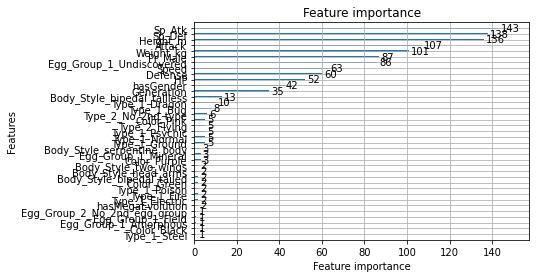

In [77]:
lgb.plot_importance(clf)

In [87]:
#percentage feature importances
featureImp=pd.DataFrame(clf.feature_importance()/clf.feature_importance().sum(),columns=['importance'])


In [88]:
featureImp['feature']=X.columns

In [91]:
# Sorted by feature importance
featureImp=featureImp.sort_values('importance',ascending=False)
featureImp

,importance,feature
3,0.125219,Sp_Atk
4,0.120841,Sp_Def
10,0.119089,Height_m
1,0.093695,Attack
11,0.088441,Weight_kg
8,0.076182,Pr_Male
67,0.075306,Egg_Group_1_Undiscovered
5,0.055166,Speed
2,0.052539,Defense
0,0.045534,HP


In [92]:
# Using all features above 1% importance
finalFeatures=featureImp.loc[featureImp.importance>0.01,'feature'].tolist()

In [94]:
# Final features
finalFeatures

['Sp_Atk',
 'Sp_Def',
 'Height_m',
 'Attack',
 'Weight_kg',
 'Pr_Male',
 'Egg_Group_1_Undiscovered',
 'Speed',
 'Defense',
 'HP',
 'hasGender',
 'Generation',
 'Body_Style_bipedal_tailless']

In [95]:
#Filtering the final features
print(X.shape)
X=X[finalFeatures]
X.shape

(721, 96)


(721, 13)

# Training and testing with final features

In [117]:
#train test splitting ---- 
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=0)

In [118]:
#lightgbm 
clf = lgb.LGBMClassifier()

# convert data to lightgbm Dataset object
d_train = lgb.Dataset(X_train, label=y_train)

In [119]:
#defining parameters
SEARCH_PARAMS = {'learning_rate': 0.1,
                'max_depth': 3,
                'num_leaves': 8,
                'feature_fraction': 0.8,
                'subsample': 0.7}

FIXED_PARAMS={'objective': 'binary',
             'metric': 'accuracy',
             'bagging_freq':2,
             'boosting':'dart',
             'num_boost_round':10,
             'early_stopping_rounds':5}

params = {'metric':FIXED_PARAMS['metric'],
             'objective':FIXED_PARAMS['objective'],
             **SEARCH_PARAMS}

In [120]:
# crossvalidation
cv_results=lgb.cv(params=params,train_set=d_train,stratified=True)

[LightGBM] [Info] Number of positive: 26, number of negative: 434
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 460, number of used features: 13
[LightGBM] [Info] Number of positive: 27, number of negative: 434
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 461, number of used features: 13
[LightGBM] [Info] Number of positive: 27, number of negative: 434
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number o

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [121]:
#training
clf=lgb.train(params=params,train_set=d_train)

[LightGBM] [Info] Number of positive: 33, number of negative: 543
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 585
[LightGBM] [Info] Number of data points in the train set: 576, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.057292 -> initscore=-2.800602
[LightGBM] [Info] Start training from score -2.800602
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

In [146]:
#predicting on test set for out-of-sample accuracy
y_pred=clf.predict(X_test)

In [147]:
ypred=y_pred.copy()

In [148]:
y_pred[y_pred>0.5]=1
y_pred[y_pred<=0.5]=0

In [149]:
# Confusion Matrix - Test Set
confusion_matrix(y_pred,y_test)

array([[131,   1],
       [  1,  12]], dtype=int64)

In [150]:
# Accuracy on test set
round(accuracy_score(y_pred,y_test)*100,2)

98.62

In [152]:
# Classification report - Test Set
# Here '1' label is isLegendary==True
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99       132
         1.0       0.92      0.92      0.92        13

    accuracy                           0.99       145
   macro avg       0.96      0.96      0.96       145
weighted avg       0.99      0.99      0.99       145



In [140]:
#predicting for in-sample accuracy
y_pred=clf.predict(X_train)

In [141]:
ypred=y_pred.copy()

In [142]:
y_pred[y_pred>0.5]=1
y_pred[y_pred<=0.5]=0

In [143]:
# Confusion Matrix
confusion_matrix(y_pred,y_train)

array([[543,   0],
       [  0,  33]], dtype=int64)

In [144]:
# Thus in-sample accuracy is 100%
round(accuracy_score(y_pred,y_train)*100,2)

100.0

In [153]:
clf

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

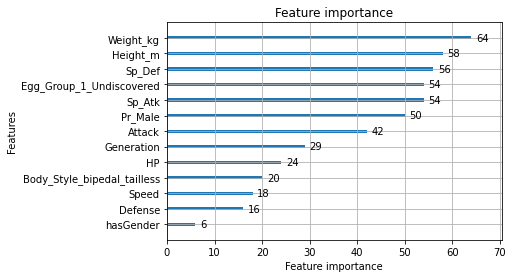

In [156]:
lgb.plot_importance(clf)

In [ ]:
# This is lightgbm hyperparameter tuning code - 
# I have not used it as the data is very less for an advanced model like lightgbm

# count=0
# tuningDF=pd.DataFrame()
# max_depthList=[2,3,4,5,6]
# num_boost_roundList=[10,20,30,40,50]

# for depth in max_depthList:
#     for rounds in num_boost_roundList:
#         #defining parameters
#         SEARCH_PARAMS = {'learning_rate': 0.05,
#                         'max_depth': depth,
#                         'feature_fraction': 0.7,
#                         'subsample': 0.7}

#         FIXED_PARAMS={'objective': 'binary',
#                      'metric': 'accuracy',
#                      'bagging_freq':2,
#                      'boosting':'dart',
#                      'num_boost_round':rounds,
#                      'early_stopping_rounds':5}

#         params = {'metric':FIXED_PARAMS['metric'],
#                      'objective':FIXED_PARAMS['objective'],
#                      **SEARCH_PARAMS}

#         # crossvalidation
#         cv_results=lgb.cv(params=params,train_set=d_train,stratified=True,verbose_eval=0)

#         clf=lgb.train(params=params,train_set=d_train)
        
#         #make predictions
#         y_pred=clf.predict(X_test)
# #         acc = accuracy(y_test, y_pred, squared=False)
#         print(cv_results)
#         if cv_results:
#             count+=1
# #         print({'Best num_boost_rounds':len(cv_results['accuracy']),
# #                         'Best score:': cv_results['accuracy'][-1],'Test score':acc,
# #                         'depth':depth,'rounds':rounds})
# #         tuningDF=tuningDF.append({'Best num_boost_rounds':len(cv_results['accuracy']),
# #                         'Best score:': cv_results['accuracy'][-1],'Test score':acc,
# #                         'depth':depth,'rounds':rounds},ignore_index=True)